# Satellite Image Classification using Convolutional Neural Network and EuroSAT

## Libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns


from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

## Config

In [30]:
ROOT_PATH = os.getcwd()
BASE_PATH = os.path.join(ROOT_PATH, 'Image_Dataset')
DATA_PATH = os.path.join(ROOT_PATH, 'Dataset')
FULL_DATA_DF = os.path.join(ROOT_PATH, 'FULL_DATA.csv')

if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
    CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.1


In [33]:
CLASS_IDX_LABELS

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

## Utils

In [22]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [23]:
## Example for decoding and encoding
print(encode_label('Forest'), decode_target(2))
print(decode_target(2, text_labels=True))

1 HerbaceousVegetation
HerbaceousVegetation


## Pre-Processing data folders to train and test
Run this code cells only if you don't have the required dataframe

In [24]:
from os import walk
i = 0
for (dirpath, dirname, filename) in walk(BASE_PATH):
    print("Directory Path: ", dirpath)
    print("Directory Name: ", dirname)
    print("Filename : ", filename)
    print("----------------------"*10)
    i += 1
    if i > 3:
        break

Directory Path:  /home/pipebomb/Desktop/Land-Cover-Classification-using-Sentinel-2-Dataset/Image_Dataset
Directory Name:  ['Forest', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Highway', 'PermanentCrop', 'Pasture', 'AnnualCrop', 'Residential', 'River']
Filename :  []
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Directory Path:  /home/pipebomb/Desktop/Land-Cover-Classification-using-Sentinel-2-Dataset/Image_Dataset/Forest
Directory Name:  []
Filename :  ['Forest_2484.jpg', 'Forest_2824.jpg', 'Forest_223.jpg', 'Forest_2643.jpg', 'Forest_285.jpg', 'Forest_335.jpg', 'Forest_1002.jpg', 'Forest_2409.jpg', 'Forest_709.jpg', 'Forest_2044.jpg', 'Forest_862.jpg', 'Forest_1506.jpg', 'Forest_1900.jpg', 'Forest_2310.jpg', 'Forest_2365.jpg', 'Forest_331.jpg', 'Forest_3000.jpg', 'Forest_176.jpg', 'Forest_1113.jpg', 'Fores

In [37]:
from os import walk

i = 0
DATA_DF = pd.DataFrame(columns = ['image_id', 'label'], dtype=object) 

for (dirpath, dirname, filename) in walk(BASE_PATH):
    for each_file in filename:
        DATA_DF.loc[i] = [each_file, dirpath.split('/')[-1]]
        i += 1
        # break
DATA_DF.to_csv(FULL_DATA_DF, index=False)
DATA_DF.head()


,image_id,label
0,Forest_2484.jpg,Forest
1,Forest_2824.jpg,Forest
2,Forest_223.jpg,Forest
3,Forest_2643.jpg,Forest
4,Forest_285.jpg,Forest


## Processing data folders to train and test


In [38]:
DATA_DF = pd.read_csv(FULL_DATA_DF)
DATA_DF = DATA_DF.sample(frac = 1, random_state=48) 
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*VALID_SIZE)]
VALID_DF = DATA_DF[-int(len(DATA_DF)*VALID_SIZE) :]

In [39]:
TRAIN_DF.reset_index(inplace = True) 
TRAIN_DF.head()

,index,image_id,label
0,19127,AnnualCrop_355.jpg,AnnualCrop
1,3197,SeaLake_260.jpg,SeaLake
2,24557,River_1729.jpg,River
3,17042,Pasture_258.jpg,Pasture
4,3697,SeaLake_767.jpg,SeaLake


In [40]:
VALID_DF.reset_index(inplace = True) 
VALID_DF.head()

,index,image_id,label
0,21985,Residential_2887.jpg,Residential
1,25621,River_1892.jpg,River
2,21573,Residential_2060.jpg,Residential
3,25070,River_1667.jpg,River
4,13947,Highway_936.jpg,Highway


In [41]:
TRAIN_DF.size, VALID_DF.size

(72900, 8100)

## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [42]:
class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img = Image.open(os.path.join(self.train_dir, img_id.split('.')[0].split('_')[0], img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

### Transformations and Datasets

In [43]:
## Dataset and transformations
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
train_ds = EuroSAT(TRAIN_DF, BASE_PATH, data_transform)
valid_ds = EuroSAT(VALID_DF, BASE_PATH, data_transform)
print(len(train_ds), len(valid_ds))

24300 2700


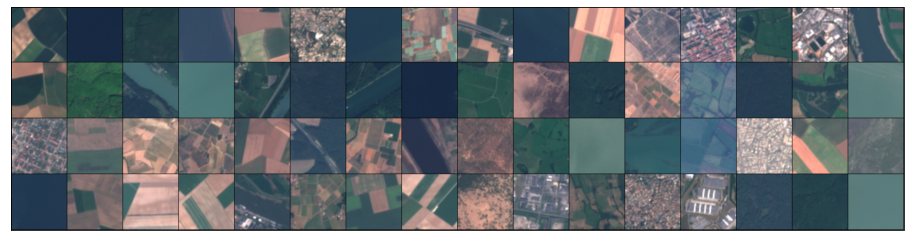

In [44]:
## Data loaders and showing batch of data
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

## Model

In [45]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [46]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [47]:
model = LULC_Model()

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /home/pipebomb/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [ ]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:  
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
try_batch(train_dl)